## Non-variational fixed-depth Hamiltonian simulation

Here we time the FDHS example with non-variational KAK decomposition.

In [17]:
from itertools import combinations, product
import numpy as np
import time
np.random.seed(2415)
from scipy.linalg import expm, logm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from pennylane import X, Y, Z, I

from kak_tools import (
    map_simple_to_irrep,
    map_irrep_to_matrices,
    lie_closure_pauli_words,
    recursive_bdi,
    map_recursive_decomp_to_reducible,
    map_recursive_decomp_to_reducible_str,
    irrep_dot,
    make_signs,
    make_so_2n,
    make_so_2n_horizontal_mapping,
    make_so_2n_full_mapping,
    make_so_2n_full_mapping_str,
    round_mult_recursive_decomp_str,
)
from memory_profiler import profile

In [18]:
# Helper functions
def make_so_2n_hamiltonian(n, coefficients="random"):
    couplings = [X(w) @ X(w+1) for w in range(n-1)] + [Y(w) @ Y(w+1) for w in range(n-1)]
    Zs = [Z(w) for w in range(n)]
    generators = couplings + Zs
    if coefficients == "random":
        alphas = np.random.normal(0.6, 1., size=n-1)
        betas = np.random.normal(0.3, 1.2, size=n-1)
        gammas = np.random.normal(0., 0.3, size=n)
    elif coefficients == "random TF":
        alphas = np.ones(n-1)
        betas = np.ones(n-1)
        gammas = np.random.normal(0., 0.3, size=n)
    elif coefficients == "uniform":
        alphas = np.ones(n-1)
        betas = np.ones(n-1)
        gammas = np.ones(n)
    
    coeffs = np.concatenate([alphas, betas, gammas])
    coeffs /= np.linalg.norm(coeffs) # Normalization
    H = qml.dot(coeffs, generators)
    generators = [next(iter(op.pauli_rep)) for op in generators]
    return H, generators, coeffs


# Helper functions
def make_so_2n_hamiltonian_str(n, coefficients="random"):
    generators = (
        [f"{i}X0X{n-i-2}" for i in range(n-1)]
        + [f"{i}Y0Y{n-i-2}" for i in range(n-1)]
        + [f"{i}Z{n-i-1}" for i in range(n-1)]
    )
    # print(generators)
    if coefficients == "random":
        alphas = np.random.normal(0.6, 1., size=n-1)
        betas = np.random.normal(0.3, 1.2, size=n-1)
        gammas = np.random.normal(0., 0.3, size=n)
    elif coefficients == "random TF":
        alphas = np.ones(n-1)
        betas = np.ones(n-1)
        gammas = np.random.normal(0., 0.3, size=n)
    elif coefficients == "uniform":
        alphas = np.ones(n-1)
        betas = np.ones(n-1)
        gammas = np.ones(n)
    
    coeffs = np.concatenate([alphas, betas, gammas])
    coeffs /= np.linalg.norm(coeffs) # Normalization
    return generators, coeffs

In [19]:
# Config

coefficients = "random"
use_predefined_algebra = True
use_predefined_horizontal_mapping = True
use_hardcoded_mapping = True
ns = np.arange(2, 23, dtype=int) ** 2
num_reps = 1
tols = list(10.**np.linspace(-3, -1, 10))
ns = [50]
print(ns)

[50]


In [20]:
# @profile
def run(n, coefficients, tol, algebra=None):
    if algebra is not None:
        raise ValueError
    # H, generators, coeffs = make_so_2n_hamiltonian(n, coefficients)
    generators, coeffs = make_so_2n_hamiltonian_str(n, coefficients)
    n_so = 2 * n
    so_dim = (n_so**2-n_so) // 2
    print("hamiltonian done")
    
    ################################################
    start = time.process_time()
    # assert len(algebra) == so_dim, f"{len(algebra)}, {so_dim}"

    ###   ###   ###   ###   ###   ###   ###   ###   ###
    start_mapping = time.process_time()
    
    # if not use_hardcoded_mapping:
    #     if use_predefined_horizontal_mapping:
    #         horizontal_ops = make_so_2n_horizontal_mapping(n)
    #     else:
    #         horizontal_ops = generators
    #     # print(f"Mapping simple to irrep")
    #     mapping, signs = map_simple_to_irrep(algebra, horizontal_ops=horizontal_ops, n=n_so, invol_type="BDI", invol_kwargs={"p": n_so//2, "q": (n_so+1)//2})
    #     # print(f"Mapping irrep to matrices")
    # else:
    mapping = make_so_2n_full_mapping_str(n)
    # signs = make_signs(mapping, n_so, "BDI")

    end_mapping = time.process_time()
    ###   ###   ###   ###   ###   ###   ###   ###   ###
    print("mapping done")
    
    epsilon = 0.01
    # print(f"Computing H and time evolution")
    H_irrep = irrep_dot(coeffs, generators, mapping, n=n_so, invol_type="BDI")
    U = expm(epsilon * H_irrep)

    ###   ###   ###   ###   ###   ###   ###   ###   ###
    start_decomposing = time.process_time()
    recursive_decomp = recursive_bdi(U, n_so, validate=True)
    end_decomposing = time.process_time()
    ###   ###   ###   ###   ###   ###   ###   ###   ###

    
    ###   ###   ###   ###   ###   ###   ###   ###   ###
    start_mapping_back = time.process_time()
    pauli_decomp = map_recursive_decomp_to_reducible_str(recursive_decomp, mapping, time=epsilon, tol=tol)

    U_rounded = round_mult_recursive_decomp_str(recursive_decomp, time=epsilon, n_so=n_so, tol=tol)
    assert np.allclose(U_rounded @ U_rounded.T, np.eye(n_so))
    
    error_unitary = expm(-H_irrep) @ U_rounded
    assert np.allclose(error_unitary @ error_unitary.T, np.eye(n_so))
    # print(error_unitary)
    error_generator = logm(error_unitary)
    error_norm = np.linalg.norm(np.triu(error_generator / 2), ord="fro")
    print(f"tol: {tol}, error: {error_norm}")
    # wire_map = {i: i for i in range(n)}
    # paulirot_decomp = [(coeff, qml.pauli.pauli_word_to_string(pw, wire_map), pw.wires, _type) for pw, coeff, _type in pauli_decomp]
    end_mapping_back = time.process_time()
    ###   ###   ###   ###   ###   ###   ###   ###   ###
    
    end = time.process_time()
    ################################################

    t_map = end_mapping - start_mapping
    t_dec = end_decomposing - start_decomposing
    t_map_back = end_mapping_back - start_mapping_back
    return pauli_decomp, t_map, t_dec, t_map_back, end - start, end - start - t_map - t_map_back - t_dec

In [21]:
Times_mapping = []
Times_decomposing = []
Times_mapping_back = []
Times_rest = []
Times_total = []


for tol in tols:
    for n in ns:
        n = int(n)
        n_so = 2 * n
        so_dim = (n_so**2-n_so) // 2
        
        times_mapping = []
        times_decomposing = []
        times_mapping_back = []
        times_rest = []
        times_total = []
        # if use_predefined_algebra:
        #     algebra = make_so_2n(n)
        # else:
        #     algebra = lie_closure_pauli_words(generators, verbose=False)
        print("algebra done")
        for _ in tqdm(range(num_reps)):
            paulirot_decomp, t_map, t_dec, t_map_back, t_tot, t_r = run(n, coefficients, algebra=None, tol=tol)
            times_mapping.append(t_map)
            times_decomposing.append(t_dec)
            times_mapping_back.append(t_map_back)
            times_total.append(t_tot)
            times_rest.append(t_r)
            
            print(f"Decomposed exp(iHt) on {n} qubits into {len(paulirot_decomp)} Pauli rotations (DLA dimension: {so_dim}, Duration: {times_total[-1]:.3}s).")
        Times_mapping.append(np.mean(times_mapping))
        Times_decomposing.append(np.mean(times_decomposing))
        Times_mapping_back.append(np.mean(times_mapping_back))
        Times_total.append(np.mean(times_total))
        Times_rest.append(np.mean(times_rest))

algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


/home/david/repos/kak-tools/kak_tools/dense_cartan.py:205: RuntimeWarning: invalid value encountered in arcsin
  angle = np.arcsin(matrix[i, j])
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


tol: 0.001, error: 1.2133720811855278
Decomposed exp(iHt) on 50 qubits into 4612 Pauli rotations (DLA dimension: 4950, Duration: 1.02s).
algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


tol: 0.0016681005372000592, error: 1.434715483348094
Decomposed exp(iHt) on 50 qubits into 4545 Pauli rotations (DLA dimension: 4950, Duration: 1.08s).
algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


tol: 0.0027825594022071257, error: 1.4623264433801133
Decomposed exp(iHt) on 50 qubits into 4574 Pauli rotations (DLA dimension: 4950, Duration: 1.06s).
algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


tol: 0.004641588833612777, error: 1.3018430811674524
Decomposed exp(iHt) on 50 qubits into 4500 Pauli rotations (DLA dimension: 4950, Duration: 1.12s).
algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


tol: 0.007742636826811269, error: 1.2984035527245381
Decomposed exp(iHt) on 50 qubits into 4467 Pauli rotations (DLA dimension: 4950, Duration: 1.01s).
algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


tol: 0.01291549665014884, error: 1.4051445309018107
Decomposed exp(iHt) on 50 qubits into 4446 Pauli rotations (DLA dimension: 4950, Duration: 1.09s).
algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


tol: 0.021544346900318832, error: 1.4294152488362606
Decomposed exp(iHt) on 50 qubits into 4398 Pauli rotations (DLA dimension: 4950, Duration: 1.02s).
algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


tol: 0.03593813663804626, error: 1.4461703811669544
Decomposed exp(iHt) on 50 qubits into 4345 Pauli rotations (DLA dimension: 4950, Duration: 1.08s).
algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


tol: 0.05994842503189409, error: 1.4336192985194618
Decomposed exp(iHt) on 50 qubits into 4185 Pauli rotations (DLA dimension: 4950, Duration: 1.03s).
algebra done


  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

hamiltonian done
mapping done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]

tol: 0.1, error: 1.376749604594342
Decomposed exp(iHt) on 50 qubits into 4036 Pauli rotations (DLA dimension: 4950, Duration: 0.989s).


/tmp/ipykernel_162604/25188044.py:8: RuntimeWarning: invalid value encountered in power
  f = lambda x, a, b: (b * x)**a
/tmp/ipykernel_162604/25188044.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f, ns[:len(times)], times)


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

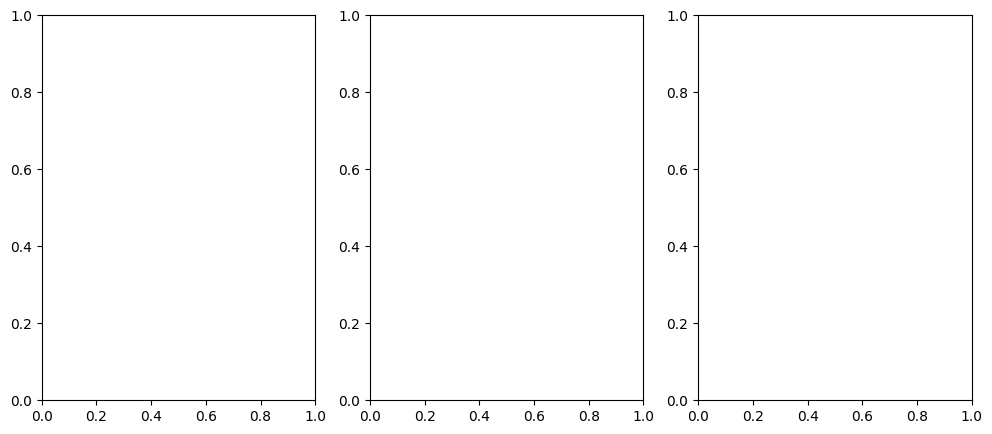

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
all_times = [Times_total, Times_decomposing, Times_mapping, Times_mapping_back, Times_rest]
colors = ["xkcd:indigo", "xkcd:blue violet", "xkcd:red pink", "xkcd:orange yellow", "xkcd:seafoam green"]
labels = ["Total", "Decomposing", "Mapping", "Mapping back", "Rest"]
accum_times = 0
for times, label, c in zip(all_times, labels, colors):
    # f = lambda x, a, b: a * x + b
    f = lambda x, a, b: (b * x)**a
    # popt, pcov = curve_fit(f, np.log(ns)[3:], np.log(times)[3:])
    skip_fit = False
    try:
        popt, pcov = curve_fit(f, ns[:len(times)], times)
    except:
        skip_fit = True
    cont_ns = np.linspace(ns[0], ns[-1], 100)
    
    ax = axs[0]
    ax.plot(ns[:len(times)], times, marker="s", c=c, label=label, ls="")
    # ax.plot(cont_ns, np.exp(f(np.log(cont_ns), *popt)), ls = "--", c="xkcd:red pink", label=f"${popt[1]:.1f}n^{{{popt[0]:.2f}}}$")
    if not skip_fit:
        ax.plot(cont_ns, f(cont_ns, *popt), ls = "--", c=c, label=f"$({popt[1]:.3f}n)^{{{popt[0]:.2f}}}$")
    ax.set_xlabel("Number of qubits $n$")
    ax.set_ylabel("Decomposition runtime $t$ / s")
    ax.legend()
    
    ax = axs[1]
    ax.plot(np.log(ns[:len(times)]), np.log(times), marker="s", c=c, label=label, ls="")
    # ax.plot(np.log(ns), f(np.log(ns), *popt), ls = "--", c="xkcd:red pink", label=f"${popt[0]:.2f}\ \log n {popt[1]:.1f}$")
    if not skip_fit:
        ax.plot(np.log(cont_ns), np.log(f(cont_ns, *popt)), ls = "--", c=c, label=f"${popt[0]:.2f}\ \log n {popt[0] * np.log(popt[1]):.2f}$")
    ax.set_xlabel("$\log n$")
    ax.set_ylabel("$\log (t/\\text{s})$")
    ax.legend()
    
    ax = axs[2]
    if label!="Total":
        ax.bar(ns[:len(times)], times, bottom=accum_times, width=10, color=c, label=label)
        accum_times += np.array(times)
    ax.set_xlabel("Number of qubits $n$")
    ax.set_ylabel("Runtime $t$ / s")
    # ax.set_yscale("log")
    ax.legend()
plt.savefig("../gfx/fdhs_performance.pdf", dpi=300)

In [ ]:
print(times_rest[-1])
# %prun make_so_2n_full_mapping(n)
# %prun make_signs(mapping, n_so, "BDI")
# %prun irrep_dot(coeffs, generators, mapping, signs, n=n_so, invol_type="BDI") # 0.26
# %prun expm(epsilon * H_irrep) # 0.02
# %prun [(coeff, qml.pauli.pauli_word_to_string(pw, wire_map), pw.wires, _type) for pw, coeff, _type in pauli_decomp]
# %prun recursive_bdi(U, n_so, validate=False)